In [142]:
%matplotlib inline

import ipywidgets as widgets
import cv2
import PIL.Image
from ipywidgets import interact
from pathlib import Path
from IPython.display import display, Image, clear_output
from skorch.net import NeuralNet
from common import get_train_test_split_from_paths, get_train_valid_transformers, fscore_as_metric
from pprint import pprint
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import json
import torch
import io

from dataset import UsgDataset
from model import PretrainedModel

In [19]:
model_path = "models/lower_adam_without_augmentation/params.pt"
data_folder = "/data/Datasets/usg-kaggle/"

In [122]:
weights_path = Path(model_path)
assert weights_path.exists()

data_paths = list((Path(data_folder) / "train").rglob("radial_polar_area.png"))

classes = [int(path.parent.parent.name) for path in data_paths]
train_paths, valid_paths = get_train_test_split_from_paths(data_paths, classes)
valid_paths = np.asarray(valid_paths)
paths_to_consider = np.asarray(paths_to_consider)


valid_dataset = UsgDataset(paths_to_consider, True, transforms=get_train_valid_transformers())

net = NeuralNet(
    PretrainedModel,
    criterion=nn.CrossEntropyLoss,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=2,
    iterator_valid__batch_size=1,
    device="cuda",
)
net.initialize()
net.load_params(f_params=weights_path.as_posix())

valid_predictions = net.predict(valid_dataset)
valid_pred_classes = np.argmax(valid_predictions, axis=1)
valid_trues = np.asarray([int(path.parent.parent.name) for path in paths_to_consider])

In [131]:
fscore_as_metric(valid_predictions, valid_trues)

0.8476494831020258

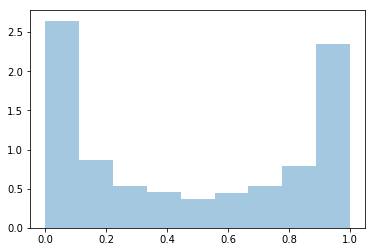

In [132]:
probas = np.exp(valid_predictions) / np.sum(np.exp(valid_predictions), axis=1, keepdims=True)
sns.distplot(probas[:, 1], kde=False, norm_hist=True)

In [140]:
same_predictions = valid_pred_classes == valid_trues
paths_where_same = paths_to_consider[same_predictions]
paths_where_not_same = paths_to_consider[~same_predictions]
len(paths_where_same), len(paths_where_not_same)

(2332, 419)

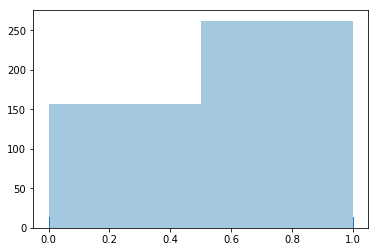

In [141]:
sns.distplot([int(path.parent.parent.name) for path in paths_where_not_same], kde=False, rug=True, bins=2)

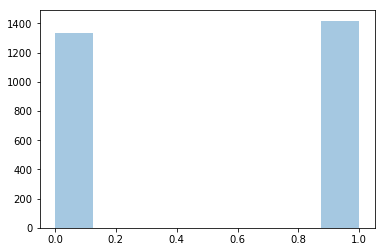

In [153]:
sns.distplot(valid_trues, kde=False, norm_hist=False)

Text(0.5, 15.0, 'Pred labels')

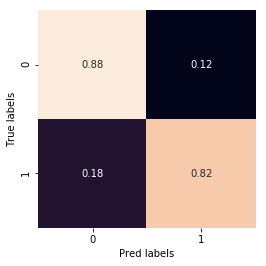

In [150]:
conf_matrix = confusion_matrix(valid_trues, valid_pred_classes)
ax = sns.heatmap(conf_matrix / conf_matrix.sum(axis=1, keepdims=True), cbar=False, fmt=".2f", annot=True, square=True)
ax.set_ylabel('True labels')
ax.set_xlabel('Pred labels')

In [54]:
not_same_dropdown = widgets.IntSlider(
    min=0,
    max=len(paths_where_not_same) - 1,
    value=0
)
@interact(index=not_same_dropdown)
def see_wrong_predicitons(index):
    a_path = paths_where_not_same[index]
    img = cv2.imread(a_path.as_posix(), cv2.IMREAD_GRAYSCALE)
    plt.title(f'Class: {a_path.parent.parent.name}, Confidence: {probas[index]}')
    plt.imshow(img, cmap='gray')
    pprint(json.loads((a_path.parent / 'left_side_annotation.json').read_text()))

interactive(children=(IntSlider(value=0, description='index', max=136), Output()), _dom_classes=('widget-inter…

## Input optimisation

In [113]:
a_model = PretrainedModel()
a_model.load_state_dict(torch.load(weights_path.as_posix()))
a_model = a_model.eval()

In [90]:
def display_image(img):
    pil_image = PIL.Image.fromarray(img)
    clear_output()
    byte_array = io.BytesIO()
    pil_image.save(byte_array, format='PNG')
    byte_array = byte_array.getvalue()
    display(Image(byte_array))

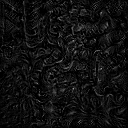

tensor(14.1474, grad_fn=<SelectBackward>)


In [157]:
example_input = np.random.random((1, 1, 128, 128)).astype(np.float32)
example_input = np.concatenate([example_input] * 3, axis=1)
example_input = torch.from_numpy(example_input)
example_input.requires_grad = True
iters = 100
class_ind = 1
display_image((example_input.detach().cpu().numpy()[0].transpose((1, 2, 0))  * 255).astype(np.uint8))
for i in range(iters):
    example_input.requires_grad = True
    output = a_model(example_input)
    output = torch.relu(output)
    loss = output[:, class_ind]
    loss.backward()
    grads = example_input.grad 
    example_input = example_input.detach()
    example_input = example_input + grads / grads.std() * 0.1
    example_input /= example_input.max()
    example_input = example_input.mean(dim=1, keepdim=True)
    example_input = torch.cat([example_input] * 3, dim=1)
    example_input = torch.clamp(example_input, 0, 1)
    display_image((example_input.cpu().numpy()[0].transpose((1, 2, 0))  * 255).astype(np.uint8))
    print(output[0, class_ind])